# Data

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
import yfinance as yf

In [3]:
# the 1h data only available within 2 years
sp500 = yf.download("^GSPC", start="2021-04-26", end="2023-04-25", interval="1h")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^GSPC: 1h data not available for startTime=1619409600 and endTime=1682395200. The requested range must be within the last 730 days.


In [23]:
sp500 = sp500['Adj Close'] - sp500['Open']

In [32]:
sp500.values

array([ 2.81982422,  1.33007812, -5.31005859, ...,  2.62011719,
        2.75      ,  2.83984375])

## Modeling

In [19]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque

2023-04-27 10:49:12.450798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [118]:
class Agent:
        def __init__(self, state_size, is_eval=False, model_name=""):
            self.state_size = state_size # normalized previous days
            self.action_size = 3 # hold, buy, sell
            self.memory = deque(maxlen=1000)
            self.inventory = []
            self.model_name = model_name
            self.is_eval = is_eval
            self.gamma = 0.99
            self.epsilon = 1.0
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.99
            self.model = load_model(model_name) if is_eval else self._model()
            self.loss_l = []
            self.val_loss_l = []

        def _model(self):
            model = Sequential()
            model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
            model.add(Dense(units=32, activation="relu"))
            model.add(Dense(units=8, activation="relu"))
            model.add(Dense(self.action_size, activation="linear"))
            model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
            return model

        def act(self, state):
            if not self.is_eval and random.random()<= self.epsilon:
                return random.randrange(self.action_size)
            options = self.model.predict(state, verbose=0)
            return np.argmax(options[0])

        def optimize(self, batch_size):
            mini_batch = []
            l = len(self.memory)
            for i in range(l - batch_size + 1, l):
                mini_batch.append(self.memory[i])
            for state, action, reward, next_state, done in mini_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
                target_f = self.model.predict(state, verbose=0)
                target_f[0][action] = target
                train_history = self.model.fit(state, target_f, epochs=1, verbose=0)
                self.loss_l.append(train_history.history['loss'])
                #self.val_loss_l.append(train_history.history['val_loss'])
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

In [88]:
def sigmoid(x):
    return 1/(1+math.exp(-x))

def getState(data, t, n):

    if t < 5:
        window = -(t-n+1)*[data[0]] + list(data[0: t+1])
    else:
        window = data[t-n+1:t + 1]

    return np.array(window).reshape((1, n))


Training the Agent
Depending on the action that is predicted by the model, the buy/sell call adds or subtracts money. It trains via multiple episodes which are the same as epochs in deep learning.

In [94]:
data = sp500.values # np.ndarray
window_size = 5 # state space size, consist with previous window_size days
agent = Agent(window_size)
num_episodes = 100
l = len(data) - 1
batch_size = 32
t_p = []
for i_episode in range(num_episodes + 1):
    print("Episode " + str(i_episode) + "/" + str(num_episodes))
    state = getState(data, 0, window_size)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size)#) + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # positive income from the transactions or 0
            reward = max(data[t] - bought_price, 0)
            # cumulative profit for the episode
            total_profit += data[t] - bought_price
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            t_p.append(total_profit)
    if len(agent.memory) > batch_size:
        agent.optimize(batch_size)
    if i_episode % 50 == 0:
        agent.model.save(str(i_episode))


/Users/xinluliu/opt/anaconda3/envs/TF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Episode 0/100
INFO:tensorflow:Assets written to: 0/assets
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
INFO:tensorflow:Assets written to: 10/assets
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
INFO:tensorflow:Assets written to: 20/assets
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
INFO:tensorflow:Assets written to: 30/assets
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
INFO:tensorflow:Assets written to: 40/assets
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100


KeyboardInterrupt: 

Text(37.597222222222214, 0.5, 'Total profit')

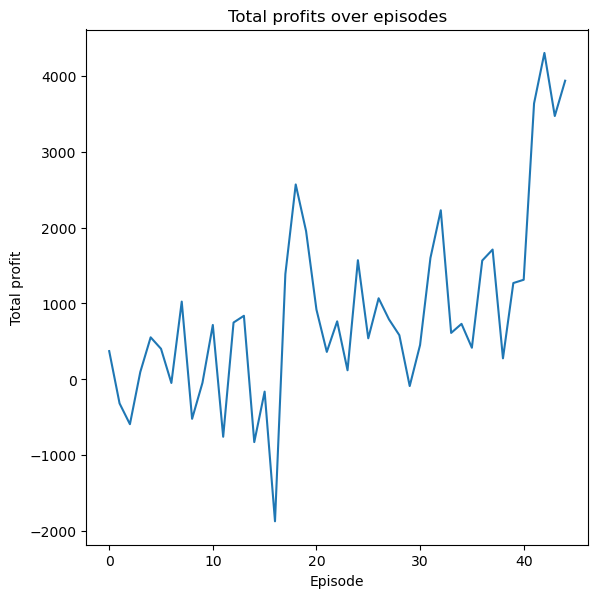

In [98]:
# DEFINE YOUR VISUALIZATION
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(t_p)-5), t_p[:-5],)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")

In [115]:
def getState(data, t, n):
    window = data[100+t-n+1:100+t + 1]
    return window.reshape((1, n))


In [106]:
from data_simulation import process_price_traces

start_price =  100
alpha = 1.0
time_steps = 100
num_traces = 500

process_traces = process_price_traces(
    start_price=start_price,
    alpha=alpha,
    time_steps=time_steps,
    num_traces=num_traces
)

In [119]:
data = process_traces # np.ndarray
window_size = 100 # state space size, consist with previous window_size days
agent = Agent(window_size)
num_episodes = 1000
l = len(data) - 101
batch_size = 32
t_p = []
for i_episode in range(num_episodes):
    print("Episode " + str(i_episode) + "/" + str(num_episodes))
    state = getState(data[i_episode], 0, window_size)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data[i_episode], t + 1, window_size)#) + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[i_episode][t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # positive income from the transactions or 0
            reward = max(data[i_episode][t] - bought_price, 0)
            # cumulative profit for the episode
            total_profit += data[i_episode][t] - bought_price
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            t_p.append(total_profit)
    if i_episode % 50 == 0:
        if len(agent.memory) > batch_size:
            agent.optimize(batch_size)
        #agent.model.save(str(i_episode))


Episode 0/1000
INFO:tensorflow:Assets written to: 0/assets
Episode 1/1000
Episode 2/1000
Episode 3/1000
Episode 4/1000
Episode 5/1000
Episode 6/1000
Episode 7/1000
Episode 8/1000
Episode 9/1000
Episode 10/1000
INFO:tensorflow:Assets written to: 10/assets
Episode 11/1000
Episode 12/1000
Episode 13/1000
Episode 14/1000
Episode 15/1000
Episode 16/1000
Episode 17/1000
Episode 18/1000
Episode 19/1000
Episode 20/1000
INFO:tensorflow:Assets written to: 20/assets
Episode 21/1000
Episode 22/1000
Episode 23/1000
Episode 24/1000
Episode 25/1000
Episode 26/1000
Episode 27/1000
Episode 28/1000
Episode 29/1000
Episode 30/1000
INFO:tensorflow:Assets written to: 30/assets
Episode 31/1000
Episode 32/1000
Episode 33/1000
Episode 34/1000
Episode 35/1000
Episode 36/1000
Episode 37/1000
Episode 38/1000
Episode 39/1000
Episode 40/1000
INFO:tensorflow:Assets written to: 40/assets
Episode 41/1000
Episode 42/1000
Episode 43/1000
Episode 44/1000
Episode 45/1000
Episode 46/1000
Episode 47/1000
Episode 48/1000
Ep

KeyboardInterrupt: 

Text(37.597222222222214, 0.5, 'Total profit')

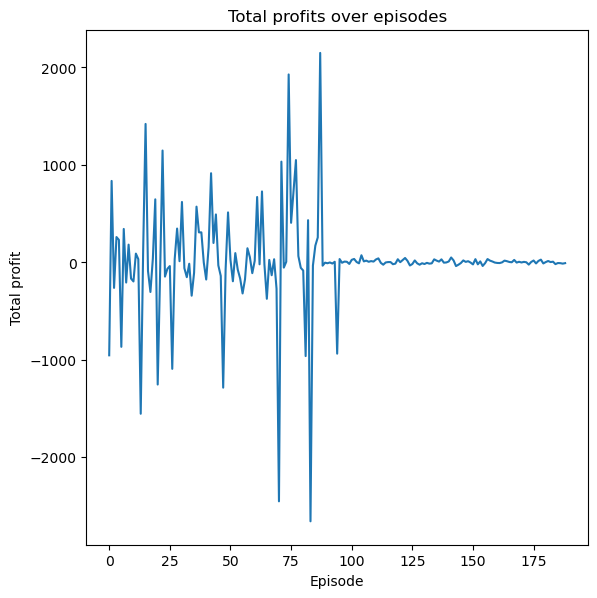

In [241]:
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(t_p)), t_p,)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")

In [136]:
np.array(agent.loss_l).reshape(1, 5852)

array([[2.80665601e+03, 4.20798492e+02, 2.43459523e-01, ...,
        7.49814853e-06, 1.11683876e-04, 7.49904393e-06]])

In [148]:
vector_norm = agent.loss_l/np.linalg.norm(agent.loss_l)

Text(37.597222222222214, 0.5, 'Training Loss')

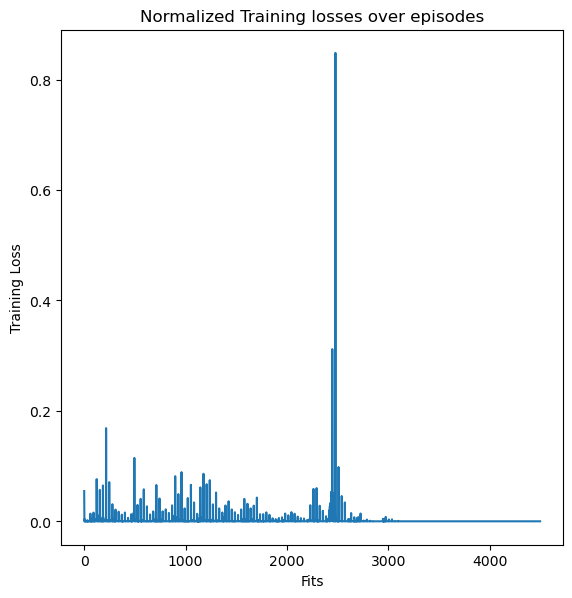

In [242]:
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

fig.tight_layout(pad=2)

axs.plot(np.array(range(4500)).astype(int), vector_norm[:4500])#list(np.array(agent.loss_l)),)
axs.set_title("Normalized Training losses over episodes")
axs.set_xlabel("Fits")
axs.set_ylabel("Training Loss")
